In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import copy
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule
import torchvision
from torchvision.models import resnet18,efficientnet_b0
from torchvision import datasets, transforms
import torch.nn as nn
from copy import deepcopy
from torchvision import datasets, transforms
from astra.torch.metrics import f1_score,precision_score,recall_score
from astra.torch.utils import train_fn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm,trange
import pandas as pd
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimCLRTransform, utils
from lightly.data import LightlyDataset
from lightly.transforms import SimSiamTransform
from torchvision.transforms import ToPILImage

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# path to all models and data
path = "/home/vannsh.jani/brick_kilns/ssl_exp"
# inside this folder there are various folders for different models and data

In [4]:
x_train = torch.load(f"{path}/data/ban_x_train_50.pt") # 50% Bangladesh
y_train = torch.load(f"{path}/data/ban_y_train_50.pt")

In [5]:
x_test = torch.load(f"{path}/data/delhi.pt")  # 100% Delhi
y_test = torch.load(f"{path}/data/delhi_new_labels.pt")

In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([12749, 3, 224, 224]),
 torch.Size([12749]),
 torch.Size([10025, 3, 224, 224]),
 torch.Size([10025]))

In [7]:
# Downstream model
eff = torchvision.models.efficientnet_b0(pretrained=True)
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet = nn.Sequential(*list(eff.children())[:-1])
        self.resnet.load_state_dict(torch.load("")) # load different weights
        self.fc = nn.Linear(1280,num_classes)

    def forward(self, x):
        x = self.resnet(x).flatten(start_dim=1)
        return self.fc(x)

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
## Imagenet model
model1 = efficientnet_b0(pretrained=True)
model1.classifier[1] = nn.Linear(1280, 2)
model1.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
def get_metrics(y_pred,y_label):
    with torch.no_grad():
        f1 = f1_score(y_pred,y_label)
        precision = precision_score(y_pred,y_label)
        recall = recall_score(y_pred,y_label)
        return f1,precision,recall

In [10]:
# train function, # save data every k epochs
def train(model, X_train, y_train, criterion, epochs, lr, verbose,model_name,data="bangladesh",k=10, batch_size=256): # model name for saving different models 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    model.to(device)
    epoch_losses = []
    f1_list = []
    precision_list = []
    recall_list = []
    epoch_k_loss = []
    # train_dataset = TensorDataset(X_train, y_train)
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    X_train = X_train.float()
    for epoch in trange(epochs, desc="Epochs"):
        batch_losses = []  # Track losses per batch
        y_total_pred = []
        for i in trange(0, len(X_train), batch_size):
            optimizer.zero_grad()
            X_batch = X_train[i:i+batch_size].to(device)
            y_batch = y_train[i:i+batch_size].to(device)
            y_pred = model(X_batch).to(device)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            y_total_pred.append(y_pred)

        # Calculate average loss for the epoch
        epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_loss)
        
        if verbose:
            print(f"Epoch: {epoch} Loss: {epoch_loss}")
        if (epoch+1)%k == 0 or epoch ==epochs-1:
            epoch_k_loss.append(epoch_loss)
            with torch.no_grad():
                f,p,r = get_metrics(torch.cat(y_total_pred).argmax(dim=1).cpu(),y_train.cpu())
                f1_list.append(f)
                precision_list.append(p)
                recall_list.append(r)
            torch.save(model.state_dict(),f"{path}/{model_name}/{epoch+1}_{data}.pth")
           
            


    return epoch_losses,f1_list,precision_list,recall_list,epoch_k_loss


In [11]:
# testing function

def predict(model,X_test,y_test,criterion,batch_size = 32):
    result_dict = {}
    X_test = X_test.float()
    test_loss = []
    with torch.no_grad():
        model.eval()
        # incorporating batch size
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        y_pred = []
        for x, y in tqdm(test_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output,y.long())
            y_pred.append(output)
            test_loss.append(loss)
        y_pred = torch.cat(y_pred)
        # print(y_pred)
        y_pred = torch.argmax(y_pred,dim=1)
        # print(y_pred)
        y_pred = y_pred.cpu()
        y_test = y_test.cpu()
        # print(y_pred.dtype,y_test.dtype)
        f1,precision,recall = get_metrics(y_pred,y_test)

        avg_loss = sum(test_loss)/len(test_loss)
        result_dict = {"f1":f1.item(),"precision":precision.item(),"recall":recall.item(),"loss":avg_loss}
        return result_dict


In [12]:
# no ssl training is required, only finetuning left, for which we can load weights into downstream model
# and use train and test functions to get results

In [13]:
epoch_losses,f1_list,precision_list,recall_list,epoch_k_loss = train(model1,x_train,y_train,nn.CrossEntropyLoss(),100,1e-3,True,"imagenet",k=10)

Epochs:   1%|          | 1/100 [00:13<22:42, 13.76s/it]

Epoch: 0 Loss: 0.09750772014260292


Epochs:   2%|▏         | 2/100 [00:27<21:58, 13.46s/it]

Epoch: 1 Loss: 0.033715575467795134


Epochs:   3%|▎         | 3/100 [00:40<21:37, 13.38s/it]

Epoch: 2 Loss: 0.01594622626202181


Epochs:   4%|▍         | 4/100 [00:52<20:36, 12.88s/it]

Epoch: 3 Loss: 0.013116754413349554


Epochs:   5%|▌         | 5/100 [01:05<20:35, 13.01s/it]

Epoch: 4 Loss: 0.013018815091345459


Epochs:   6%|▌         | 6/100 [01:17<19:56, 12.73s/it]

Epoch: 5 Loss: 0.00962987884413451


Epochs:   7%|▋         | 7/100 [01:29<19:25, 12.54s/it]

Epoch: 6 Loss: 0.006785736043821089


Epochs:   8%|▊         | 8/100 [01:42<19:21, 12.63s/it]

Epoch: 7 Loss: 0.009382647927559447


Epochs:   9%|▉         | 9/100 [01:55<19:08, 12.62s/it]

Epoch: 8 Loss: 0.009807105659856461


Epochs:  10%|█         | 10/100 [02:07<18:43, 12.49s/it]

Epoch: 9 Loss: 0.006578138633922208


Epochs:  11%|█         | 11/100 [02:20<18:34, 12.52s/it]

Epoch: 10 Loss: 0.004861443551635603


Epochs:  12%|█▏        | 12/100 [02:33<18:31, 12.63s/it]

Epoch: 11 Loss: 0.005722414733318146


Epochs:  13%|█▎        | 13/100 [02:45<18:05, 12.48s/it]

Epoch: 12 Loss: 0.006309905143571087


Epochs:  14%|█▍        | 14/100 [02:57<17:43, 12.37s/it]

Epoch: 13 Loss: 0.0038888605294414447


Epochs:  15%|█▌        | 15/100 [03:09<17:27, 12.32s/it]

Epoch: 14 Loss: 0.0021924169237172463


Epochs:  16%|█▌        | 16/100 [03:22<17:34, 12.55s/it]

Epoch: 15 Loss: 0.002455764042933879


Epochs:  17%|█▋        | 17/100 [03:35<17:24, 12.59s/it]

Epoch: 16 Loss: 0.002334679947634868


Epochs:  18%|█▊        | 18/100 [03:47<17:00, 12.44s/it]

Epoch: 17 Loss: 0.0014081433827232105


Epochs:  19%|█▉        | 19/100 [03:59<16:39, 12.34s/it]

Epoch: 18 Loss: 0.0018915356248544414


Epochs:  20%|██        | 20/100 [04:11<16:23, 12.29s/it]

Epoch: 19 Loss: 0.0005346242272207747


Epochs:  21%|██        | 21/100 [04:24<16:16, 12.35s/it]

Epoch: 20 Loss: 0.0022452076325316737


Epochs:  22%|██▏       | 22/100 [04:36<16:15, 12.50s/it]

Epoch: 21 Loss: 0.005667556481494102


Epochs:  23%|██▎       | 23/100 [04:49<15:54, 12.40s/it]

Epoch: 22 Loss: 0.004921364907786483


Epochs:  24%|██▍       | 24/100 [05:01<15:38, 12.35s/it]

Epoch: 23 Loss: 0.0014014091678836848


Epochs:  25%|██▌       | 25/100 [05:14<15:37, 12.50s/it]

Epoch: 24 Loss: 0.0008473530792616657


Epochs:  26%|██▌       | 26/100 [05:26<15:23, 12.48s/it]

Epoch: 25 Loss: 0.00028139359850683834


Epochs:  27%|██▋       | 27/100 [05:38<15:03, 12.37s/it]

Epoch: 26 Loss: 0.0015386940338794374


Epochs:  28%|██▊       | 28/100 [05:51<14:58, 12.48s/it]

Epoch: 27 Loss: 0.004352275175697287


Epochs:  29%|██▉       | 29/100 [06:04<14:50, 12.54s/it]

Epoch: 28 Loss: 0.005711667626273993


Epochs:  30%|███       | 30/100 [06:16<14:29, 12.43s/it]

Epoch: 29 Loss: 0.005586470236521563


Epochs:  31%|███       | 31/100 [06:28<14:21, 12.49s/it]

Epoch: 30 Loss: 0.0017642641344718867


Epochs:  32%|███▏      | 32/100 [06:41<14:16, 12.59s/it]

Epoch: 31 Loss: 0.0016275041336848517


Epochs:  33%|███▎      | 33/100 [06:53<13:53, 12.45s/it]

Epoch: 32 Loss: 0.0011878910645464202


Epochs:  34%|███▍      | 34/100 [07:06<13:41, 12.45s/it]

Epoch: 33 Loss: 0.0007203728277636401


Epochs:  35%|███▌      | 35/100 [07:19<13:37, 12.58s/it]

Epoch: 34 Loss: 0.002014111060598225


Epochs:  36%|███▌      | 36/100 [07:31<13:18, 12.48s/it]

Epoch: 35 Loss: 0.0020521108613320393


Epochs:  37%|███▋      | 37/100 [07:43<13:02, 12.42s/it]

Epoch: 36 Loss: 8.389449024434725e-05


Epochs:  38%|███▊      | 38/100 [07:56<12:58, 12.56s/it]

Epoch: 37 Loss: 3.707816234964412e-05


Epochs:  39%|███▉      | 39/100 [08:09<12:43, 12.51s/it]

Epoch: 38 Loss: 2.792165229948296e-05


Epochs:  40%|████      | 40/100 [08:21<12:25, 12.42s/it]

Epoch: 39 Loss: 0.0002611035993140831


Epochs:  41%|████      | 41/100 [08:34<12:20, 12.54s/it]

Epoch: 40 Loss: 0.003665295422924828


Epochs:  42%|████▏     | 42/100 [08:46<12:07, 12.54s/it]

Epoch: 41 Loss: 0.006706645759841194


Epochs:  43%|████▎     | 43/100 [08:58<11:47, 12.41s/it]

Epoch: 42 Loss: 0.002112274815881392


Epochs:  44%|████▍     | 44/100 [09:11<11:39, 12.49s/it]

Epoch: 43 Loss: 0.0016195738020905993


Epochs:  45%|████▌     | 45/100 [09:24<11:31, 12.57s/it]

Epoch: 44 Loss: 0.002832693900927552


Epochs:  46%|████▌     | 46/100 [09:36<11:11, 12.43s/it]

Epoch: 45 Loss: 0.003276001865087892


Epochs:  47%|████▋     | 47/100 [09:48<11:00, 12.45s/it]

Epoch: 46 Loss: 0.0020277934021578404


Epochs:  48%|████▊     | 48/100 [10:01<10:54, 12.58s/it]

Epoch: 47 Loss: 0.00297669945497546


Epochs:  49%|████▉     | 49/100 [10:13<10:35, 12.47s/it]

Epoch: 48 Loss: 0.0013128707751275215


Epochs:  50%|█████     | 50/100 [10:26<10:21, 12.44s/it]

Epoch: 49 Loss: 0.00034651401185328726


Epochs:  51%|█████     | 51/100 [10:39<10:15, 12.57s/it]

Epoch: 50 Loss: 0.0001304929385514697


Epochs:  52%|█████▏    | 52/100 [10:51<10:00, 12.50s/it]

Epoch: 51 Loss: 0.001160950405001131


Epochs:  53%|█████▎    | 53/100 [11:03<09:42, 12.39s/it]

Epoch: 52 Loss: 0.0010308867084040684


Epochs:  54%|█████▍    | 54/100 [11:16<09:36, 12.54s/it]

Epoch: 53 Loss: 0.004510134273768927


Epochs:  55%|█████▌    | 55/100 [11:29<09:24, 12.55s/it]

Epoch: 54 Loss: 0.005281770538385899


Epochs:  56%|█████▌    | 56/100 [11:41<09:06, 12.42s/it]

Epoch: 55 Loss: 0.0020060188662682776


Epochs:  57%|█████▋    | 57/100 [11:53<08:57, 12.49s/it]

Epoch: 56 Loss: 0.002283793260648963


Epochs:  58%|█████▊    | 58/100 [12:06<08:48, 12.58s/it]

Epoch: 57 Loss: 0.0034659555666075904


Epochs:  59%|█████▉    | 59/100 [12:18<08:30, 12.44s/it]

Epoch: 58 Loss: 0.0018789180480962386


Epochs:  60%|██████    | 60/100 [12:31<08:18, 12.46s/it]

Epoch: 59 Loss: 0.0005641392774123233


Epochs:  61%|██████    | 61/100 [12:44<08:10, 12.58s/it]

Epoch: 60 Loss: 0.0005356454028515145


Epochs:  62%|██████▏   | 62/100 [12:56<07:53, 12.47s/it]

Epoch: 61 Loss: 0.0011393260203840328


Epochs:  63%|██████▎   | 63/100 [13:08<07:38, 12.40s/it]

Epoch: 62 Loss: 0.0016381472971261247


Epochs:  64%|██████▍   | 64/100 [13:21<07:31, 12.55s/it]

Epoch: 63 Loss: 0.004604505752613477


Epochs:  65%|██████▌   | 65/100 [13:33<07:18, 12.52s/it]

Epoch: 64 Loss: 0.0010222544280259172


Epochs:  66%|██████▌   | 66/100 [13:46<07:01, 12.40s/it]

Epoch: 65 Loss: 0.0009357373794045998


Epochs:  67%|██████▋   | 67/100 [13:58<06:53, 12.54s/it]

Epoch: 66 Loss: 0.001604820720731368


Epochs:  68%|██████▊   | 68/100 [14:11<06:42, 12.56s/it]

Epoch: 67 Loss: 0.0010371170351118053


Epochs:  69%|██████▉   | 69/100 [14:23<06:25, 12.43s/it]

Epoch: 68 Loss: 0.00020355080990611896


Epochs:  70%|███████   | 70/100 [14:36<06:15, 12.50s/it]

Epoch: 69 Loss: 0.0011618970246036042


Epochs:  71%|███████   | 71/100 [14:49<06:05, 12.60s/it]

Epoch: 70 Loss: 0.0006599054679827532


Epochs:  72%|███████▏  | 72/100 [15:01<05:48, 12.46s/it]

Epoch: 71 Loss: 0.0007136155247735587


Epochs:  73%|███████▎  | 73/100 [15:13<05:35, 12.44s/it]

Epoch: 72 Loss: 0.0008055340384635201


Epochs:  74%|███████▍  | 74/100 [15:26<05:26, 12.57s/it]

Epoch: 73 Loss: 7.907807943411172e-05


Epochs:  75%|███████▌  | 75/100 [15:38<05:12, 12.49s/it]

Epoch: 74 Loss: 0.0019199891648167978


Epochs:  76%|███████▌  | 76/100 [15:51<04:57, 12.41s/it]

Epoch: 75 Loss: 0.003976790553933824


Epochs:  77%|███████▋  | 77/100 [16:03<04:48, 12.56s/it]

Epoch: 76 Loss: 0.0015399348993014427


Epochs:  78%|███████▊  | 78/100 [16:16<04:35, 12.52s/it]

Epoch: 77 Loss: 0.0010054961200148683


Epochs:  79%|███████▉  | 79/100 [16:28<04:20, 12.40s/it]

Epoch: 78 Loss: 0.0019063904597987858


Epochs:  80%|████████  | 80/100 [16:41<04:10, 12.54s/it]

Epoch: 79 Loss: 0.0012499427721377287


Epochs:  81%|████████  | 81/100 [16:54<03:58, 12.57s/it]

Epoch: 80 Loss: 0.0014765911361246254


Epochs:  82%|████████▏ | 82/100 [17:06<03:43, 12.44s/it]

Epoch: 81 Loss: 0.0007515292682728614


Epochs:  83%|████████▎ | 83/100 [17:18<03:32, 12.48s/it]

Epoch: 82 Loss: 0.0001221048520073964


Epochs:  84%|████████▍ | 84/100 [17:31<03:21, 12.60s/it]

Epoch: 83 Loss: 2.9235319959752815e-05


Epochs:  85%|████████▌ | 85/100 [17:43<03:06, 12.46s/it]

Epoch: 84 Loss: 1.8487966889324527e-05


Epochs:  86%|████████▌ | 86/100 [17:56<02:54, 12.43s/it]

Epoch: 85 Loss: 0.000771829406364759


Epochs:  87%|████████▋ | 87/100 [18:08<02:43, 12.55s/it]

Epoch: 86 Loss: 4.012368363873975e-05


Epochs:  88%|████████▊ | 88/100 [18:21<02:29, 12.48s/it]

Epoch: 87 Loss: 2.3518768796293443e-05


Epochs:  89%|████████▉ | 89/100 [18:33<02:16, 12.38s/it]

Epoch: 88 Loss: 6.919112481682533e-05


Epochs:  90%|█████████ | 90/100 [18:46<02:05, 12.54s/it]

Epoch: 89 Loss: 2.5229435229903175e-05


Epochs:  91%|█████████ | 91/100 [18:58<01:52, 12.54s/it]

Epoch: 90 Loss: 1.04059137618151e-05


Epochs:  92%|█████████▏| 92/100 [19:11<01:39, 12.42s/it]

Epoch: 91 Loss: 7.084024039158976e-06


Epochs:  93%|█████████▎| 93/100 [19:23<01:27, 12.50s/it]

Epoch: 92 Loss: 0.0023608476974050063


Epochs:  94%|█████████▍| 94/100 [19:36<01:15, 12.58s/it]

Epoch: 93 Loss: 0.0037061450041801437


Epochs:  95%|█████████▌| 95/100 [19:48<01:02, 12.44s/it]

Epoch: 94 Loss: 0.002363624162680935


Epochs:  96%|█████████▌| 96/100 [20:01<00:49, 12.46s/it]

Epoch: 95 Loss: 0.0021185191286713233


Epochs:  97%|█████████▋| 97/100 [20:13<00:37, 12.59s/it]

Epoch: 96 Loss: 0.002195073963248433


Epochs:  98%|█████████▊| 98/100 [20:26<00:24, 12.47s/it]

Epoch: 97 Loss: 0.0009698331278741535


Epochs:  99%|█████████▉| 99/100 [20:38<00:12, 12.41s/it]

Epoch: 98 Loss: 0.0027425007375677522


Epochs: 100%|██████████| 100/100 [20:51<00:00, 12.51s/it]

Epoch: 99 Loss: 0.0012275032579054824


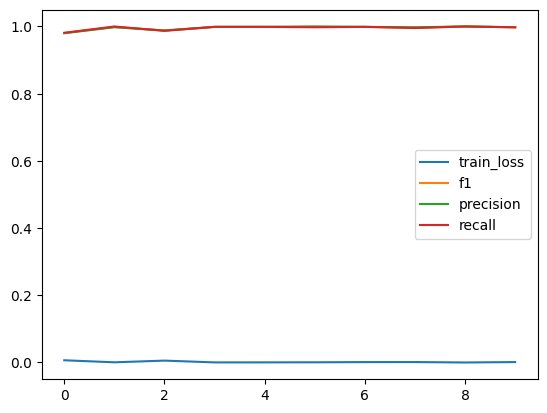

In [14]:
plt.plot(epoch_k_loss,label="train_loss")
plt.plot(f1_list,label="f1")
plt.plot(precision_list,label="precision")
plt.plot(recall_list,label="recall")
plt.legend()
plt.show()

In [15]:
epoch_values = [i for i in range(10,101,10)]
test_loss = []
f1_test = []
precision_test = []
recall_test = []
for i in epoch_values:
    model1.load_state_dict(torch.load(f"{path}/imagenet/{i}_bangladesh.pth"))
    result = predict(model1,x_test,y_test,nn.CrossEntropyLoss())
    test_loss.append(result["loss"])
    f1_test.append(result["f1"])
    precision_test.append(result["precision"])
    recall_test.append(result["recall"])


100%|██████████| 314/314 [02:02<00:00,  2.56it/s]


In [19]:
test_loss = [i.item() for i in test_loss]

([0.3560556471347809,
  0.3878737688064575,
  0.36893197894096375,
  0.3780357241630554,
  0.3387988805770874,
  0.3896122872829437,
  0.5334421992301941,
  0.30824533104896545,
  0.5900272130966187,
  0.4886903166770935],
 [0.6779859662055969,
  0.7087218761444092,
  0.6091370582580566,
  0.7067757248878479,
  0.678126871585846,
  0.6836158037185669,
  0.5354752540588379,
  0.68434739112854,
  0.5559188723564148,
  0.605314314365387],
 [0.869369387626648,
  0.8271446824073792,
  0.898876428604126,
  0.9029850959777832,
  0.8868216872215271,
  0.8310439586639404,
  0.8849557638168335,
  0.7468785643577576,
  0.872689962387085,
  0.9321357011795044],
 [0.555662214756012,
  0.6199616193771362,
  0.46065258979797363,
  0.5806142091751099,
  0.548944354057312,
  0.5806142091751099,
  0.383877158164978,
  0.631477952003479,
  0.40786948800086975,
  0.4481765925884247])

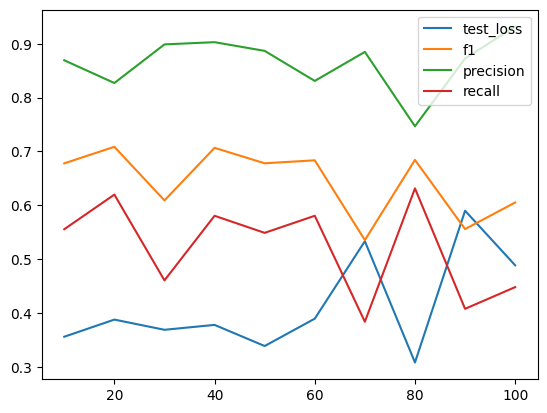

In [20]:
# plot test results
plt.plot(epoch_values,test_loss,label="test_loss")
plt.plot(epoch_values,f1_test,label="f1")
plt.plot(epoch_values,precision_test,label="precision")
plt.plot(epoch_values,recall_test,label="recall")
plt.legend()
plt.show()

In [ ]:
# save train and test results and losses
train_results = pd.DataFrame({"epoch":epoch_values,"train_loss":epoch_k_loss,"f1":f1_list,"precision":precision_list,"recall":recall_list})
test_results = pd.DataFrame({"epoch":epoch_values,"test_loss":test_loss,"f1":f1_test,"precision":precision_test,"recall":recall_test})
train_results.to_csv(f"{path}/imagenet/train_results.csv",index=False)
test_results.to_csv(f"{path}/imagenet/test_results.csv",index=False)